### Carga del dataset

Importamos los datos históricos de partidos de fútbol. Este dataset contiene columnas como la fecha del partido, el equipo local y visitante, los goles marcados por cada uno, y las cuotas de apuestas. Usaremos estas variables para construir un modelo básico de Poisson.


In [1]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv("../datasets/combined_odds_cleaned.csv")

# Mostrar primeras filas
df.head()


,Date,Season,HomeTeam,AwayTeam,FTHG,FTAG,FTR,AvgH,AvgD,AvgA
0,2003-08-30,2003-04,Albacete,Osasuna,0,2,A,2.21,3.06,2.99
1,2003-08-30,2003-04,Ath Bilbao,Barcelona,0,1,A,2.64,3.13,2.42
2,2003-08-30,2003-04,Espanol,Sociedad,1,1,D,2.58,3.10,2.48
3,2003-08-30,2003-04,Malaga,Villarreal,0,0,D,2.27,3.08,2.88
4,2003-08-30,2003-04,Real Madrid,Betis,2,1,H,1.38,4.00,7.18


### Media de goles por equipo

Calculamos la tasa media de goles (λ) que cada equipo anota como local y como visitante. Esta es la base del modelo de Poisson, donde se supone que el número de goles marcados sigue una distribución con esa media.
- Separamos goles en casa y fuera porque los equipos suelen rendir de forma diferente según si juegan como locales o visitantes, y esto afecta directamente al parámetro λ del modelo de Poisson.




In [2]:
# Media de goles anotados por equipo como local
mean_goals_home = df.groupby('HomeTeam')['FTHG'].mean().sort_values(ascending=False)

# Media de goles anotados por equipo como visitante
mean_goals_away = df.groupby('AwayTeam')['FTAG'].mean().sort_values(ascending=False)

mean_goals_home.head(), mean_goals_away.head()


(HomeTeam
 Barcelona      2.709273
 Real Madrid    2.654135
 Ath Madrid     1.884712
 Sevilla        1.766917
 Valencia       1.739348
 Name: FTHG, dtype: float64,
 AwayTeam
 Barcelona      2.082707
 Real Madrid    1.977444
 Ath Madrid     1.318296
 Girona         1.302632
 Sevilla        1.255639
 Name: FTAG, dtype: float64)

### Distribución de Poisson para un equipo específico

Aquí visualizamos la probabilidad de marcar 0, 1, 2... goles en casa para un equipo concreto (Real Madrid), utilizando su media histórica de goles como local. Esta es la distribución de Poisson con parámetro λ igual a esa media.


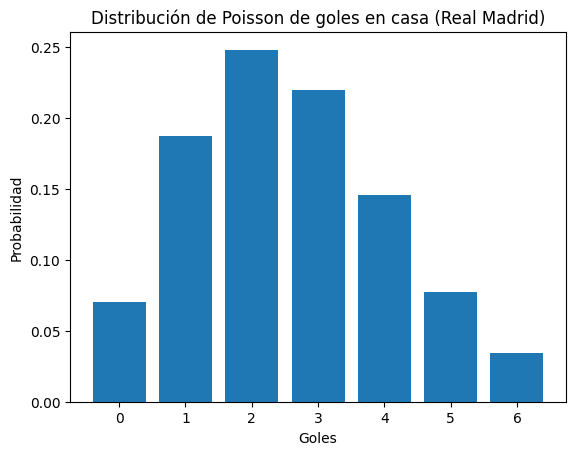

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import poisson

equipo = "Real Madrid"
lambda_rm = mean_goals_home[equipo]

x = range(0, 7)
y = poisson.pmf(x, mu=lambda_rm)

plt.bar(x, y)
plt.title(f"Distribución de Poisson de goles en casa ({equipo})")
plt.xlabel("Goles")
plt.ylabel("Probabilidad")
plt.show()


### Comparación de equipos

Comparamos la distribución de goles esperados como local entre distintos equipos. Esto permite ver cuáles equipos tienen un ataque más potente, según el modelo de Poisson simple.

**Conclusión**

Aunque todos los equipos muestran una distribución similar, se observan pequeñas diferencias en la probabilidad de marcar más de 2 goles: Barcelona y Real Madrid tienen colas más largas, lo que refleja una mayor capacidad ofensiva como locales, mientras que Sevilla, Valencia y Ath. Madrid tienden a concentrarse en marcadores más bajos.


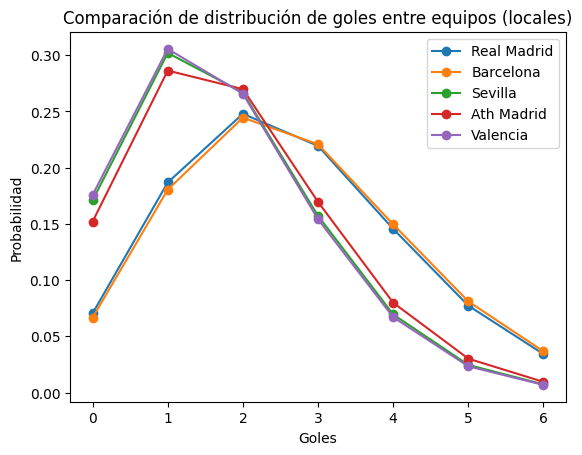

In [10]:
teams_to_compare = ["Real Madrid", "Barcelona", "Sevilla", "Ath Madrid", "Valencia"]
colors = ["blue", "green", "red", "orange", "purple"]

for team, color in zip(teams_to_compare, colors):
    lmbda = mean_goals_home[team]
    plt.plot(x, poisson.pmf(x, mu=lmbda), label=team, marker='o')

plt.title("Comparación de distribución de goles entre equipos (locales)")
plt.xlabel("Goles")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()


### Resumen del dataset

Se analizó la estructura del conjunto de datos para entender su cobertura temporal y consistencia. El análisis muestra que hay:

- **21 temporadas** registradas.
- **20 equipos** por temporada, lo cual es consistente con el formato habitual de LaLiga.
- **380 partidos por temporada**, correspondiente a una liga de 20 equipos jugando todos contra todos, ida y vuelta.

In [21]:
# Asegurar que la columna 'Season' es tipo string (por si acaso)
df['Season'] = df['Season'].astype(str)

# Número de temporadas distintas
num_temporadas = df['Season'].nunique()

# Partidos por temporada
partidos_por_temporada = df.groupby('Season').size()

# Agrupar por temporada sin warnings
equipos_por_temporada = (
    df.groupby('Season')
      .apply(lambda x: pd.unique(x[['HomeTeam', 'AwayTeam']].to_numpy().ravel()))
)

# Calcular número de equipos únicos por temporada
num_equipos_por_temporada = equipos_por_temporada.apply(len)


print(f"Número total de temporadas: {num_temporadas}")
print(f"Número de equipos por temporada: {num_equipos_por_temporada.iloc[0]}")
print(f"Número de partidos por temporada: {partidos_por_temporada.iloc[0]}")


Número total de temporadas: 21
Número de equipos por temporada: 20
Número de partidos por temporada: 380


C:\Users\anaig\AppData\Local\Temp\ipykernel_21608\3213821817.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.unique(x[['HomeTeam', 'AwayTeam']].to_numpy().ravel()))


### Validación del modelo de Poisson para el Real Madrid (local)

En este análisis, se aplicó un modelo de Poisson simple para predecir el número de goles del Real Madrid como local en la temporada **2023-24**, utilizando como parámetro λ la media de goles registrada en la temporada anterior **2022-23**.

Los pasos seguidos fueron:

1. **Entrenamiento**: se calculó el valor de λ como la media de goles en casa del Real Madrid en la temporada 2022-23.
2. **Predicción**: se aplicó una distribución de Poisson con ese λ para estimar la probabilidad de cada número de goles observados en los partidos de 2023-24.
3. **Evaluación**: se calculó la log-verosimilitud total y por partido, que mide qué tan probable era observar los goles reales bajo el modelo.


In [23]:
from scipy.stats import poisson
import numpy as np
import pandas as pd
from numpy import log

# Filtrar partidos del Real Madrid en casa por temporada
rm_22_23 = df[(df['HomeTeam'] == 'Real Madrid') & (df['Season'] == '2022-23')]
rm_23_24 = df[(df['HomeTeam'] == 'Real Madrid') & (df['Season'] == '2023-24')]

# Estimar lambda con temporada 2022-23
lambda_rm_22_23 = rm_22_23['FTHG'].mean()

# Predecir goles reales del 2023-24 usando lambda de 2022-23
rm_23_24 = rm_23_24.copy()  
rm_23_24['PoissonProb'] = poisson.pmf(rm_23_24['FTHG'], mu=lambda_rm_22_23)

# Calcular log-verosimilitud
log_likelihood = rm_23_24['PoissonProb'].apply(lambda p: log(p) if p > 0 else 0).sum()
log_likelihood_per_match = log_likelihood / len(rm_23_24)

# Resultados
print(f"λ estimado con temporada 2022-23: {lambda_rm_22_23:.3f}")
print(f"Log-verosimilitud total 2023-24: {log_likelihood:.4f}")
print(f"Log-verosimilitud media por partido: {log_likelihood_per_match:.4f}")


λ estimado con temporada 2022-23: 2.316
Log-verosimilitud total 2023-24: -34.8202
Log-verosimilitud media por partido: -1.8326



### Resultados

- λ estimado (2022-23): **2.316**
- Log-verosimilitud total (2023-24): **−34.8202**
- Log-verosimilitud media por partido: **−1.8326**

### Conclusión

El modelo asignó una probabilidad media del 16 % a los goles realmente marcados por el Real Madrid en casa durante la temporada 2023-24. Esto indica que, aunque el modelo capta una tendencia general del equipo, no es lo suficientemente preciso para predecir otra temporada sin ajustes adicionales, probablemente debido a variaciones en el rendimiento ofensivo o factores contextuales no modelados.

### Comparación del modelo de Poisson en los equipos más frecuentes

- Se evaluó el modelo de Poisson para predecir goles como local y como visitante.
- Para cada equipo, se usó el λ de 2022-23 para predecir goles en 2023-24.
- El ajuste se midió con log-verosimilitud media por partido.
- Valores más cercanos a 0 indican mejor ajuste.
- Las diferencias entre local y visitante muestran que el rendimiento varía según el contexto.
- Un λ fijo limita la precisión del modelo.


In [36]:
# Obtener todas las temporadas
temporadas = sorted(df['Season'].unique())

# Equipos presentes como locales en cada temporada
equipos_por_temporada = {
    temporada: set(df[df['Season'] == temporada]['HomeTeam'].unique())
    for temporada in temporadas
}

# Intersección de todos los conjuntos de equipos locales
equipos_frecuentes = set.intersection(*equipos_por_temporada.values())

# Convertir a lista ordenada alfabéticamente (opcional)
equipos_frecuentes = sorted(list(equipos_frecuentes))

# Mostrar resultados
print("Equipos presentes en todas las temporadas como locales:")
for equipo in equipos_frecuentes:
    print("-", equipo)


Equipos presentes en todas las temporadas como locales:
- Ath Bilbao
- Ath Madrid
- Barcelona
- Real Madrid
- Sevilla
- Valencia


In [39]:
equipos_frecuentes = ['Ath Bilbao', 'Ath Madrid', 'Barcelona', 'Real Madrid', 'Sevilla', 'Valencia']

# Diccionarios para almacenar resultados
loglik_home = {}
loglik_away = {}

for equipo in equipos_frecuentes:
    home_22_23 = df[(df['Season'] == '2022-23') & (df['HomeTeam'] == equipo)]
    home_23_24 = df[(df['Season'] == '2023-24') & (df['HomeTeam'] == equipo)]
    away_22_23 = df[(df['Season'] == '2022-23') & (df['AwayTeam'] == equipo)]
    away_23_24 = df[(df['Season'] == '2023-24') & (df['AwayTeam'] == equipo)]

    if len(home_22_23) == 0 or len(home_23_24) == 0 or len(away_22_23) == 0 or len(away_23_24) == 0:
        continue

    lambda_home = home_22_23['FTHG'].mean()
    lambda_away = away_22_23['FTAG'].mean()

    home_23_24 = home_23_24.copy()
    home_23_24['PoissonProb'] = poisson.pmf(home_23_24['FTHG'], mu=lambda_home)
    loglik_home[equipo] = home_23_24['PoissonProb'].apply(lambda p: log(p) if p > 0 else 0).mean()

    away_23_24 = away_23_24.copy()
    away_23_24['PoissonProb'] = poisson.pmf(away_23_24['FTAG'], mu=lambda_away)
    loglik_away[equipo] = away_23_24['PoissonProb'].apply(lambda p: log(p) if p > 0 else 0).mean()


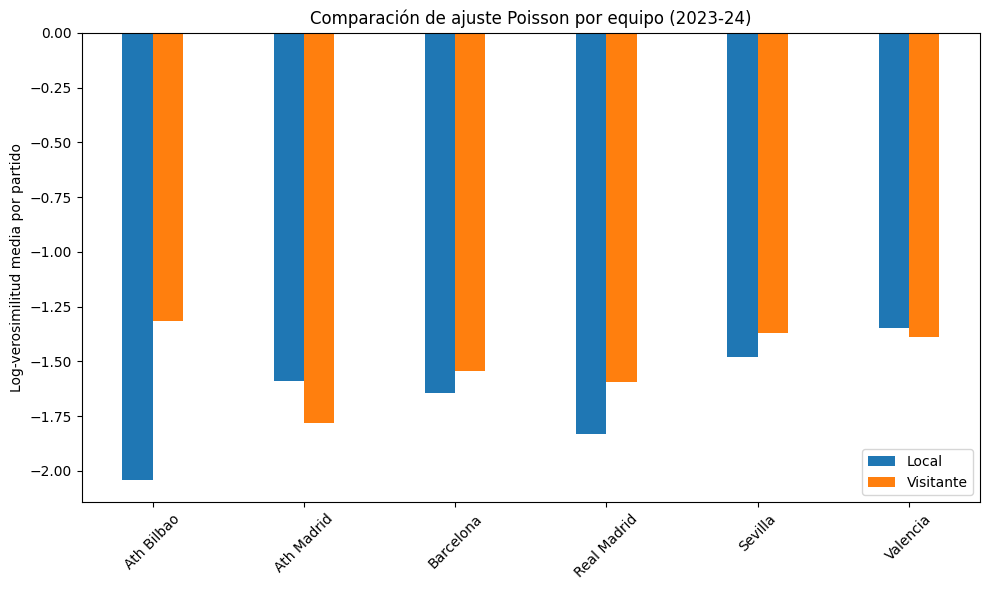

In [41]:
# Crear gráfico
df_loglik = pd.DataFrame({
    'Equipo': list(loglik_home.keys()),
    'LogLik_Local': [loglik_home[k] for k in loglik_home.keys()],
    'LogLik_Visitante': [loglik_away[k] for k in loglik_home.keys()]
})

x = np.arange(len(df_loglik['Equipo']))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, df_loglik['LogLik_Local'], width, label='Local')
ax.bar(x + width/2, df_loglik['LogLik_Visitante'], width, label='Visitante')
ax.set_ylabel('Log-verosimilitud media por partido')
ax.set_title('Comparación de ajuste Poisson por equipo (2023-24)')
ax.set_xticks(x)
ax.set_xticklabels(df_loglik['Equipo'], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

### Conclusión

- El modelo de Poisson ajusta mejor como visitante que como local.
- Athletic Club y Sevilla se ajustan bien fuera de casa.
- Athletic Club y Real Madrid tienen mal ajuste como locales.
- Un λ fijo por temporada no es suficiente en muchos casos.
- Se recomienda usar modelos que incluyan variabilidad temporal, rival y condición de localía.


### ¿Para qué sirve la log-verosimilitud?

La log-verosimilitud mide qué tan bien se ajusta un modelo probabilístico a los datos observados. En este trabajo, se utiliza para evaluar si el número de goles predicho por el modelo de Poisson coincide con los goles realmente marcados por los equipos.

- Si el modelo asigna alta probabilidad a los resultados reales, la log-verosimilitud será más alta (menos negativa). 
- En cambio, si los goles observados eran poco probables según el modelo, la log-verosimilitud será baja (más negativa).

Esta métrica permite comparar el ajuste del modelo entre equipos o temporadas, y es útil para saber si un determinado valor de λ es representativo del comportamiento ofensivo de un equipo.


### Descripción del análisis

Comparación entre la distribución de goles reales marcados en casa durante la temporada 2023-24 y la distribución teórica predicha por un modelo de Poisson. El parámetro λ utilizado en cada caso ha sido estimado a partir de la media de goles en casa de cada equipo durante la temporada 2022-23.

En cada subgráfico:
- Las barras azules muestran la frecuencia real de goles observados.
- La línea roja representa los valores esperados según la distribución de Poisson con el λ correspondiente.

Este tipo de visualización permite evaluar visualmente si el modelo ajusta bien la distribución de resultados reales de goles.


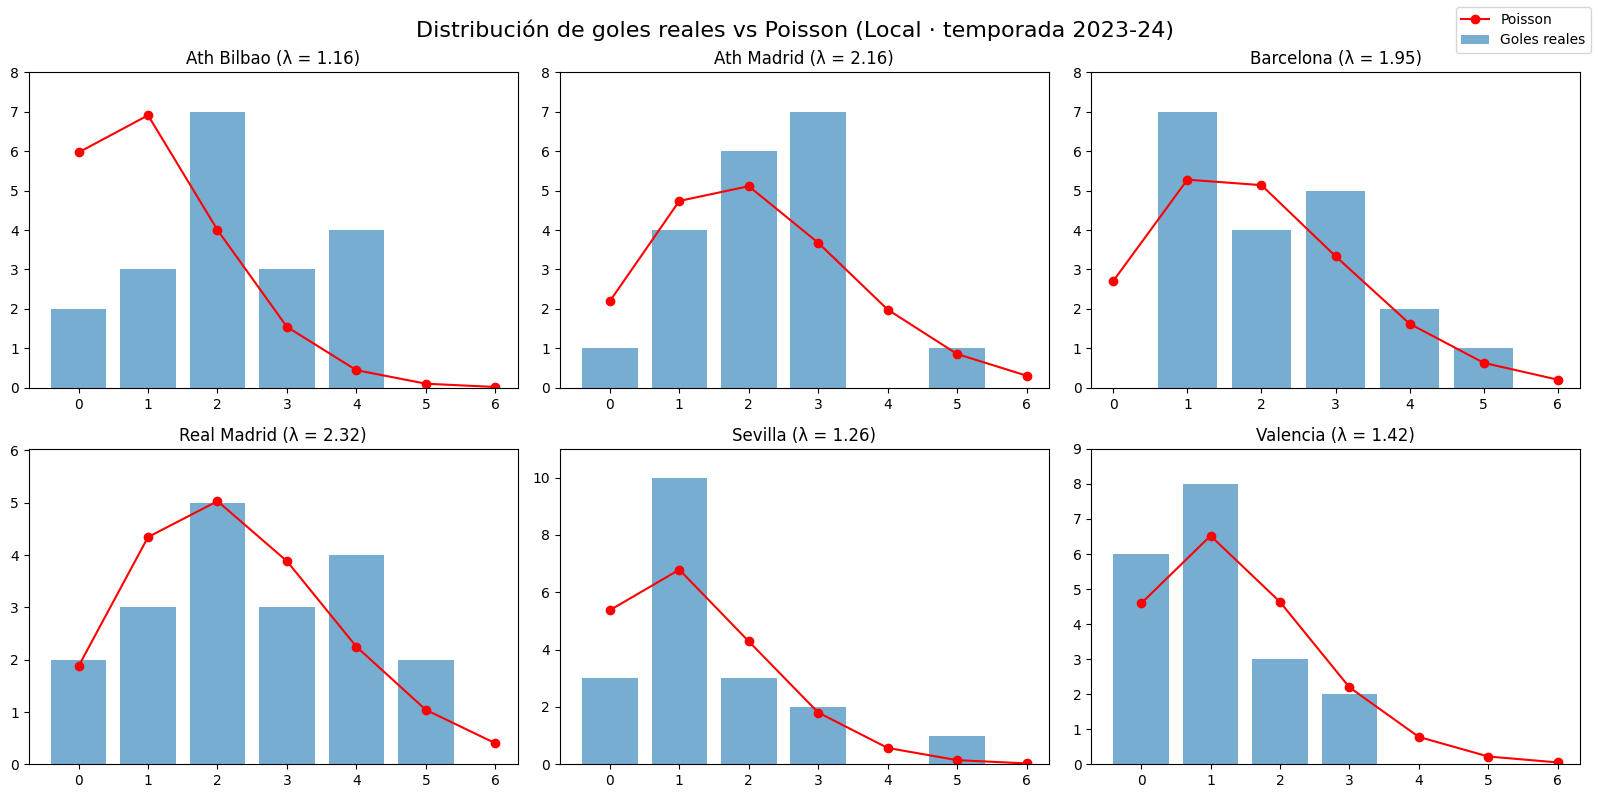

In [47]:
modo = 'local'
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

contador = 0
for equipo in equipos_frecuentes:
    if contador >= 6:
        break

    if modo == 'local':
        df_22 = df[(df['HomeTeam'] == equipo) & (df['Season'] == '2022-23')]
        df_23 = df[(df['HomeTeam'] == equipo) & (df['Season'] == '2023-24')]
        col_goles = 'FTHG'
    else:
        df_22 = df[(df['AwayTeam'] == equipo) & (df['Season'] == '2022-23')]
        df_23 = df[(df['AwayTeam'] == equipo) & (df['Season'] == '2023-24')]
        col_goles = 'FTAG'

    if len(df_22) == 0 or len(df_23) == 0:
        continue

    lambda_hat = df_22[col_goles].mean()
    goles_reales = df_23[col_goles].value_counts().sort_index()
    x = range(0, 7)
    poisson_pred = poisson.pmf(x, mu=lambda_hat) * len(df_23)

    ax = axes[contador]
    ax.bar(goles_reales.index, goles_reales.values, alpha=0.6, label='Goles reales')
    ax.plot(x, poisson_pred, marker='o', color='red', label='Poisson')
    ax.set_title(f"{equipo} (λ = {lambda_hat:.2f})")
    ax.set_xticks(x)
    ax.set_ylim(0, max(max(goles_reales.values, default=0), max(poisson_pred)) + 1)
    contador += 1

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle(f"Distribución de goles reales vs Poisson ({modo.title()} · temporada 2023-24)", fontsize=16)
plt.show()


### Conclusión

- El modelo ajusta bien en equipos como Barcelona y Atlético de Madrid.
- Fallos importantes en equipos como Athletic Club y Real Madrid, sobre todo en goles extremos.
- Un λ fijo por temporada no es suficiente en todos los casos.
- Es recomendable incorporar dinámicas temporales o variables adicionales para mejorar la predicción.


### Descripción del análisis

- Se aplica el modelo de Poisson simple a seis equipos constantes como locales.
- Se usa validación con ventana creciente: entrenar con temporadas acumuladas y validar en la siguiente.
- Se analiza la log-verosimilitud media por partido como medida de ajuste.
- Línea azul: resultado del modelo en cada validación.
- Línea roja en y = -1.5: umbral de referencia para evaluar si el ajuste es aceptable.
- Valores más cercanos a 0 indican mejor predicción del modelo.

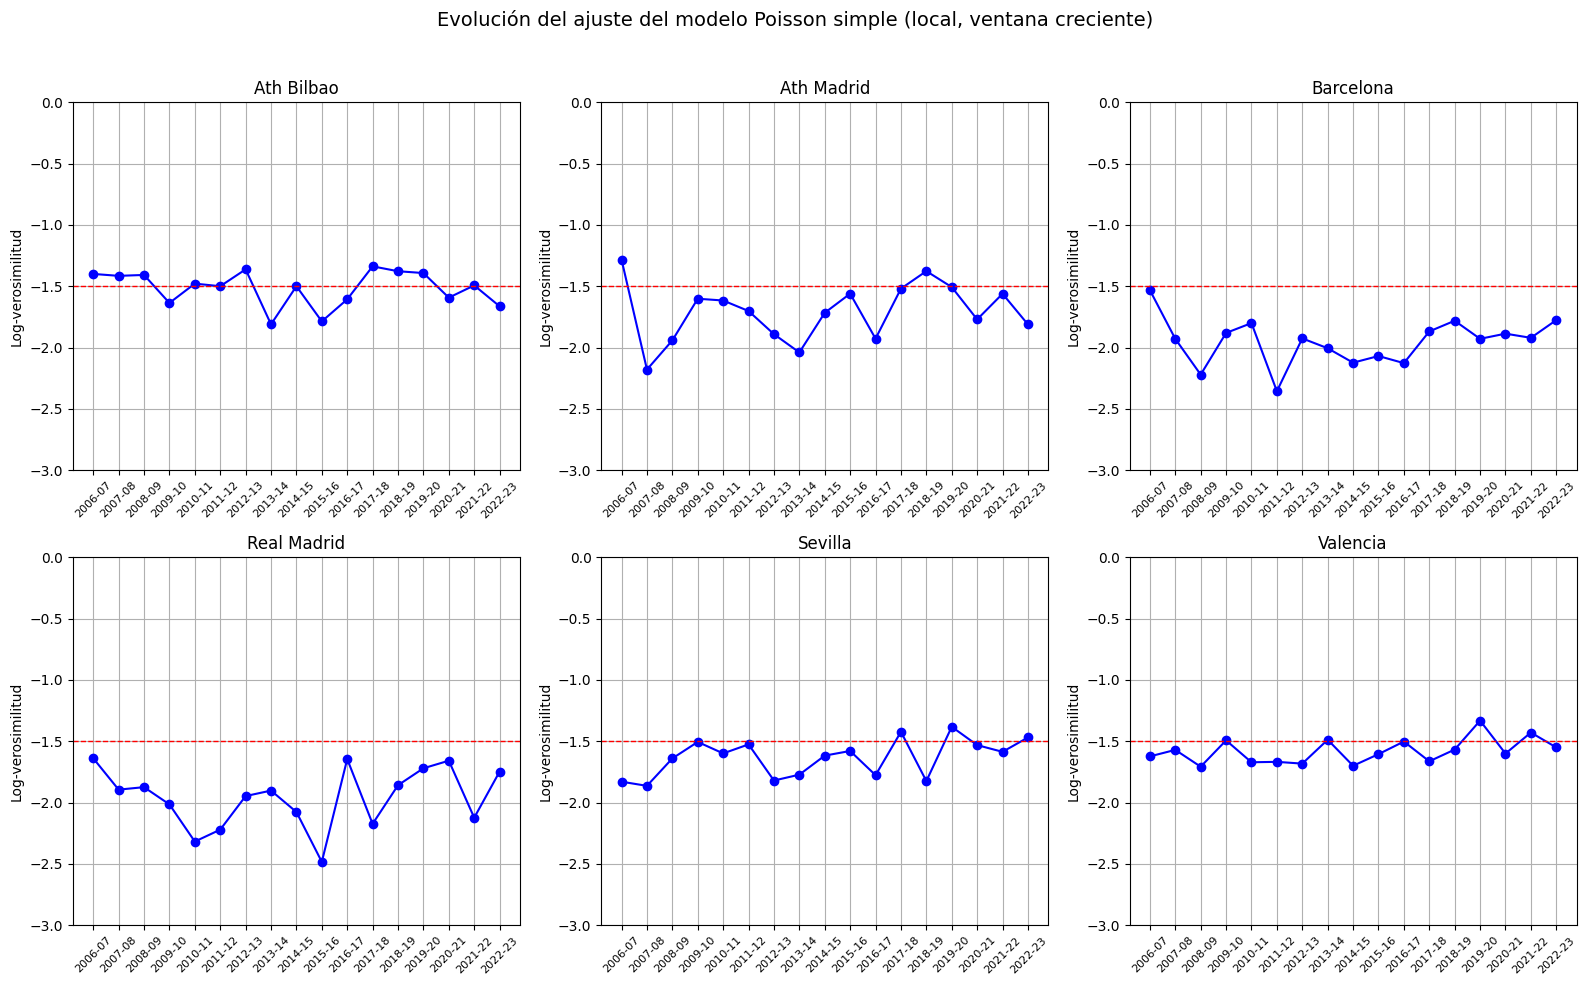

In [51]:
temporadas = sorted(df['Season'].unique())
equipos_validos = equipos_frecuentes
resultados = {equipo: [] for equipo in equipos_validos}
etiquetas_x = []

for i in range(3, len(temporadas)-1):
    temporadas_entrenamiento = temporadas[:i]
    temporada_validacion = temporadas[i]
    etiquetas_x.append(temporada_validacion)

    for equipo in equipos_validos:
        df_train = df[(df['Season'].isin(temporadas_entrenamiento)) & (df['HomeTeam'] == equipo)]
        df_val = df[(df['Season'] == temporada_validacion) & (df['HomeTeam'] == equipo)]

        if len(df_train) == 0 or len(df_val) == 0:
            resultados[equipo].append(np.nan)
            continue

        lambda_hat = df_train['FTHG'].mean()
        df_val = df_val.copy()
        df_val['PoissonProb'] = poisson.pmf(df_val['FTHG'], mu=lambda_hat)
        log_likelihood = df_val['PoissonProb'].apply(lambda p: log(p) if p > 0 else 0).mean()
        resultados[equipo].append(log_likelihood)

# Graficar
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, equipo in enumerate(equipos_validos):
    ax = axes[idx]
    valores = resultados[equipo]
    ax.plot(etiquetas_x, valores, marker='o', label=equipo, color='blue')
    ax.axhline(y=-1.5, color='red', linestyle='--', linewidth=1)
    ax.set_title(equipo)
    ax.set_xticks(etiquetas_x)
    ax.set_xticklabels(etiquetas_x, rotation=45, fontsize=8)
    ax.set_ylim(min(-3, np.nanmin(valores) - 0.2), 0)
    ax.set_ylabel("Log-verosimilitud")
    ax.grid(True)

plt.suptitle("Evolución del ajuste del modelo Poisson simple (local, ventana creciente)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Conclusión

- El modelo de Poisson simple ofrece un ajuste **estable pero limitado** en la mayoría de los equipos.
- **Sevilla y Valencia** muestran mejor comportamiento del modelo, con log-verosimilitudes cercanas a -1.5.
- **Barcelona y Real Madrid** presentan peor ajuste en varias temporadas, indicando mayor variabilidad ofensiva.
- No se observa una mejora clara al aumentar el historial de entrenamiento.
- Es necesario considerar modelos más complejos (como Poisson doble o con variables adicionales) para mejorar la capacidad predictiva.
